In [1]:
from matplotlib import pyplot as plt
import numpy as np
import random
from IPython import display

from gomoku import Gomoku
from gomoku_with_group_map import GomokuWithGroupMap
from hand_crafted_gomoku_model import HandCraftedGomokuModel
from monte_carlo_tree_search import MonteCarloTreeSearch
from parallel_monte_carlo_tree_search import ParallelMonteCarloTreeSearch

In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
shape = (19,19)

# Example with decent hand crafted model

In [4]:
game = GomokuWithGroupMap(shape)
tree_search = MonteCarloTreeSearch(game, HandCraftedGomokuModel(), 2, 10)
results = []

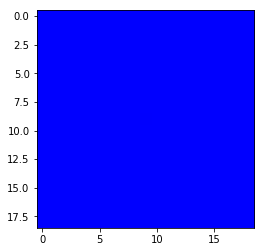

In [5]:
game.draw() 
plt.show()
for i in range(0):
    if game.game_over():
        print('Game Over')
        break
        
    result = tree_search.search()
    results.append(result)
    game.take_action(result['action'])
    
    display.clear_output(wait=True)
    print("Outcome: " + str(result['outcome']) + "  Action: " + str(result['action']))
    game.draw()    
    plt.show()

for r in results:
    print("Outcome: " + str(r['outcome']) + "  Action: " + str(r['action']))
    

# Model

In [6]:
from keras.models import Model
from keras.layers import Input, Dense, Flatten, Activation, LeakyReLU, add
from keras.layers.core import Dropout
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import GlobalAveragePooling2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Nadam

Using TensorFlow backend.


In [7]:
def res_block(width,inp):
    x = Conv2D(width, (3,3), padding='same')(inp)
    x = LeakyReLU(alpha=0.3)(x)
    x = Conv2D(width, (3,3), padding='same')(x)
    x = LeakyReLU(alpha=0.3)(x)
    x = Conv2D(width, (3,3), padding='same')(x)
    x = LeakyReLU(alpha=0.3)(x)
    x = add([x, inp])
    x = LeakyReLU(alpha=0.3)(x)
    return BatchNormalization(axis=3)(x)

In [8]:
def down_pooling_block(width,inp):
    x = Conv2D(width, (3,3), padding='same')(inp)
    x = LeakyReLU(alpha=0.3)(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Conv2D(2*width, (3,3), padding='same')(x)
    x = LeakyReLU(alpha=0.3)(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Conv2D(4*width, (3,3), padding='same')(x)
    x = LeakyReLU(alpha=0.3)(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    return x

In [9]:
hidden_layer_count = 512

input_state= Input(shape=(shape[0],shape[1],3))
x = Conv2D(hidden_layer_count, (7,7), padding='same', activation='relu')(input_state)
x = res_block(hidden_layer_count, x)
x = res_block(hidden_layer_count, x)
x = res_block(hidden_layer_count, x)

pmx = res_block(hidden_layer_count, x)
pmx = Conv2D(1, (1,1), padding='same')(pmx)
pmx = LeakyReLU(alpha=0.3)(pmx)
pmx = Flatten()(pmx)
prob_map = Activation('softmax', name='prob_map')(pmx)

#wx = down_pooling_block(hidden_layer_count, x)
wx = res_block(hidden_layer_count, x)
wx = GlobalAveragePooling2D()(wx)
wx = Dense(hidden_layer_count)(wx)
wx = LeakyReLU(alpha=0.3)(wx)
winner = Dense(1, activation='tanh', name='winner')(wx)


model = Model(input_state, [prob_map,winner])

model.compile(
    optimizer=Nadam(), 
    loss=['categorical_crossentropy','mean_squared_error'],
    loss_weights=[1, 2]
)

In [10]:
model.load_weights('/data/trained_models/gomoku_alpha_zero/gomoku_alpha_zero_resnet_weights_v4_1.h5')

# Pre train with hand crafted model

In [11]:
def action_to_onehot(action):
    result = np.zeros(shape)
    result[action] = 1
    return result

def board_augmentation(inp, out):
    sym = random.choice([' ','|','\\'])
    if sym == '|':
        inp = np.flip(inp,axis=0)
        out = np.flip(out,axis=0)
    elif sym =='\\':
        inp = np.transpose(inp, axes=(1,0,2))
        out = np.transpose(out)

    k = random.randint(0,3)
    return np.rot90(inp,k=k, axes=(0,1)), np.rot90(out,k=k, axes=(0,1))
    
        

In [ ]:
game = GomokuWithGroupMap(shape)
tree_search = MonteCarloTreeSearch(game, HandCraftedGomokuModel(), 2, 4)

In [ ]:
batch_size = 64

for batch_index in range(0):
    batch_input = []
    batch_move_pred = []
    batch_win_pred = []

    for i in range(batch_size):
        if game.game_over():
            game.reset()

        result = tree_search.search()

        board, action = board_augmentation(game.get_state_for_current_player(), action_to_onehot(result['action']))
        
        batch_input.append(board)
        batch_move_pred.append(action.flatten())
        batch_win_pred.append(result['outcome'])

        game.take_action(result['action'])

        #display.clear_output(wait=True)
        #print(str(i) + " Outcome: " + str(result['outcome']) + "  Action: " + str(result['action']))
        #game.draw()    
        #plt.show()

    losses = model.train_on_batch(np.array(batch_input), [np.array(batch_move_pred), np.array(batch_win_pred)])
    print(batch_index, losses, end="\r")

# Pre train from recorded games

In [12]:
from os import listdir
from os.path import isfile, join
import math

In [13]:
data_path = '/data/gomoku_alpha_zero/reinforcement_1'
data_files = [f for f in listdir(data_path) if isfile(join(data_path, f))]

In [14]:
train_boards = []
train_scores = []
train_actions = []

base = np.ones(shape)
base[game.get_middle()] += 1

for file in data_files:
    with open(data_path+"/"+file, 'r') as f:
        board = np.stack((np.zeros(shape), np.zeros(shape),np.copy(base)), axis=2)
        player = 0
        for line in f.readlines():
            line = line.split(',')
            
            original = np.copy(board)
            action = action_to_onehot((int(line[1]), int(line[2])))
            
            original, action = board_augmentation(original, action)
            
            train_boards.append(original)
            train_scores.append(float(line[0]))
            train_actions.append(action.flatten())
            
            board[int(line[1]), int(line[2]), player] = 1
            player = 1 - player
            
            

In [15]:
len(train_actions)

66969

In [16]:
model.fit(np.array(train_boards), [np.array(train_actions),np.array(train_scores)], shuffle=True, epochs=3, batch_size=128)

Epoch 1/3
66969/66969 [==============================] - 368s 6ms/step - loss: 5.2009 - prob_map_loss: 4.9456 - winner_loss: 0.1276
Epoch 2/3
66969/66969 [==============================] - 368s 5ms/step - loss: 5.0807 - prob_map_loss: 4.8359 - winner_loss: 0.1224
Epoch 3/3
66969/66969 [==============================] - 367s 5ms/step - loss: 5.0451 - prob_map_loss: 4.8049 - winner_loss: 0.1201


In [28]:
#model.save('/data/trained_models/gomoku_alpha_zero_resnet_full_model_v5.h5')
#model.save_weights('/data/trained_models/gomoku_alpha_zero_resnet_weights_v5.h5')

# Play with learned model

In [17]:
def choice2d(pmap, count = 10):
    shape = pmap.shape
    indices = np.transpose(np.indices(shape), axes=(1,2,0)).reshape((shape[0]*shape[1],2))
    choice_indices = np.random.choice(len(indices), count, p=pmap.reshape(shape[0]*shape[1]))
    return list(map(lambda x: tuple(x), indices[choice_indices].tolist()))

class LearnedGomokuModel:
    def __init__(self, model):
        self.model = model
    
    def predict(self, boards):
        pred = self.model.predict(boards, batch_size=256)
        shape = (boards.shape[0], boards.shape[1], boards.shape[2])
        return {
            'outcomes':pred[1].flatten(),
            'action_probability_maps': pred[0].reshape(shape)
        }
        

In [26]:
game = Gomoku(shape)
lmodel = LearnedGomokuModel(model)
tree_search = ParallelMonteCarloTreeSearch(LearnedGomokuModel(model), 2, 7)
results = []

Outcome: 1/0.0953835  Action: (12, 17)


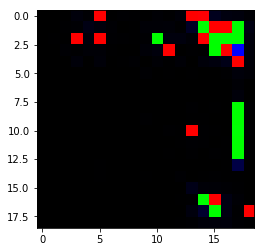

Outcome: -0.419771045446  Action: (0, 5)
Outcome: -0.403148382902  Action: (2, 15)
Outcome: -0.420039653778  Action: (3, 11)
Outcome: -0.359755933285  Action: (10, 17)
Outcome: -0.286082059145  Action: (3, 16)
Outcome: -0.234916076064  Action: (2, 17)
Outcome: -0.242825165391  Action: (17, 18)
Outcome: -0.184818804264  Action: (1, 14)
Outcome: -0.207301855087  Action: (1, 16)
Outcome: -0.249099567533  Action: (2, 16)
Outcome: -0.177550002933  Action: (0, 13)
Outcome: -0.144965007901  Action: (9, 17)
Outcome: -0.0956640392542  Action: (2, 14)
Outcome: -0.149252891541  Action: (3, 15)
Outcome: -0.148301452398  Action: (0, 14)
Outcome: -0.146466389298  Action: (16, 14)
Outcome: -0.128079175949  Action: (1, 15)
Outcome: -0.1523309201  Action: (17, 15)
Outcome: -0.0174720529467  Action: (2, 3)
Outcome: -0.0561511777341  Action: (8, 17)
Outcome: 0.0109919952229  Action: (2, 5)
Outcome: 1  Action: (11, 17)
Outcome: 0.0388913750648  Action: (10, 13)
Outcome: 1  Action: (1, 17)
Outcome: -1  Act

In [27]:
while not game.game_over():
    outcomes, actions = tree_search.search([game])
    results.append({'outcome':outcomes[0], 'action':actions[0]})
    game.take_action(actions[0])
    predicted = lmodel.predict(np.array([game.get_state_for_current_player()]))
    
    display.clear_output(wait=True)
    print("Outcome: " + str(outcomes[0]) + "/" + str(predicted['outcomes'][0]) + "  Action: " + str(actions[0]))
    pmap = predicted['action_probability_maps']
    board = game.get_state()
    plt.imshow(np.stack([board[:,:,0], board[:,:,1], pmap[0]/np.max(pmap[0])], axis = 2))
    plt.show()
    

for r in results:
    print("Outcome: " + str(r['outcome']) + "  Action: " + str(r['action']))
    

In [ ]:
lmodel = LearnedGomokuModel(model)
#lmodel = HandCraftedGomokuModel()
print(lmodel.predicted_outcome(game))
plt.imshow(lmodel.get_probability_map(game))